In [30]:
import matplotlib.pyplot as plt
import numpy as np

import foundation
from foundation.utils import plotting

In [31]:
env_config = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    "scenario_name": "scenarios/p2w",
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #     "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #     {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    "components": [
        ("Upgrade", dict(upgrade_income=10.0, upgrade_labor=1.0)),
        ("Task", dict(move_labor=1.0, collect_labor=1.0)),
        ("Recharge", dict(recharge_income=10.0, recharge_labor=1.0)),
        ("Auction", dict(order_labor=1.0, max_num_orders=5)),
        ("Shop", dict(shop_labor=1.0)),
        (
            "Adjust",
            dict(
                is_biadjust=True,
                adjust_period=50,
                adjust_rate_max=0.2,
                adjust_rate_min=0.0,
                adjust_rate_bin=0.1,
            ),
        ),
    ],
    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    "initial_p2w_setting": {"EXP": 50, "MAT": 50, "TOK": 50},
    "starting_player_token": 0,
    "starting_player_currency": 10,
    "normal_wear_and_tear_rate": 0.1,
    "player_monetary_cost_dist": "pareto",
    "player_nonmonetary_cost_dist": "normal",
    "player_utility_income_fxrate": 1.0,
    "adjust_type": "planner",
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    "n_agents": 5,  # Number of non-planner agents (must be >1)
    "world_size": [20, 20],  # [Height, Width] of the env world
    "episode_length": 100,  # Number of timesteps per episode
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    "multi_action_mode_agents": False,
    "multi_action_mode_planner": True,
    "allow_observation_scaling": True,
    "timesteps_for_force_refresh": 50,
    "full_observability": False,
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    "flatten_observations": False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    "flatten_masks": True,
}

In [32]:
def sample_random_action(agent, mask):
    """Sample random UNMASKED action(s) for agent."""
    # Return a list of actions: 1 for each action subspace
    if agent.multi_action_mode:
        split_masks = np.split(mask, agent.action_spaces.cumsum()[:-1])
        return [
            np.random.choice(np.arange(len(m_)), p=m_ / m_.sum()) for m_ in split_masks
        ]

    # Return a single action
    else:
        return np.random.choice(np.arange(agent.action_spaces), p=mask / mask.sum())


def sample_random_actions(env, obs):
    """Samples random UNMASKED actions for each agent in obs."""

    actions = {
        a_idx: sample_random_action(env.get_agent(a_idx), a_obs["action_mask"])
        for a_idx, a_obs in obs.items()
    }

    return actions

In [33]:
def play_random_episode(env, plot_every=100, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.

    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop

    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))

    obs = env.reset(force_dense_logging=do_dense_logging)

    adjust_rates = env.components[-1].adjust_rates

    for t in range(env.episode_length):
        actions = sample_random_actions(env, obs)
        obs, rew, done, info = env.step(actions)
        ax2.clear()

        curr_adjust = {
            k: adjust_rates[int(v) - 1] if v != 0 else 0
            for k, v in zip(["EXP", "MAT", "TOK"], actions["p"])
        }
        curr_setting = {
            k: int(env.base_p2w_setting[k] * (1 + v)) for k, v in curr_adjust.items()
        }
        for k, v in curr_adjust.items():
            if v == 0:
                curr_adjust[k] = "NO-OP"
            elif v > 0:
                curr_adjust[k] = "+" + str(v * 100) + "%"
            else:
                curr_adjust[k] = "-" + str(abs(v) * 100) + "%"

        text = "Steps: " + str(t) + " Period: " + str(env._periods) + "\n"
        text += "Initial P2W setting: " + str(env.base_p2w_setting) + "\n"
        text += "Current P2W setting: " + str(env.curr_p2w_setting) + "\n"
        text += "Last P2W setting: " + str(env.last_p2w_setting) + "\n\n"

        metrics = env.scenario_metrics()
        text += (
            "Profitability: "
            + str(round(metrics["social/profitability"], 2))
            + ", Equality: "
            + str(round(metrics["social/equality"], 2))
            + "\n"
        )
        text += "Planner: \nAction: " + str(curr_adjust)
        text += (
            "\nP2W setting: "
            + str(curr_setting)
            + "\n================================\n"
        )

        for i in range(len(env.all_agents) - 1):
            act = env.dense_log["actions"][t][str(i)]
            act = act if len(act) > 0 else {"NO-OP": 1}
            text += (
                "Agent "
                + str(i)
                + " :\nAction: "
                + str(act)
                + "\nInventory: "
                + str(env.world.agents[i].inventory)
                + "\nescrow: "
                + str(env.world.agents[i].escrow)
                + "\nEndogenous: "
                + str(env.world.agents[i].endogenous)
                + "\n================================\n"
            )
        ax2.text(0.05, 0.0, text, fontsize=18)
        plt.xticks([])
        plt.yticks([])

        if ((t + 1) % plot_every) == 0:
            plotting.do_plot(env, ax1, fig)

    if ((t + 1) % plot_every) != 0:
        plotting.do_plot(env, ax1, fig)

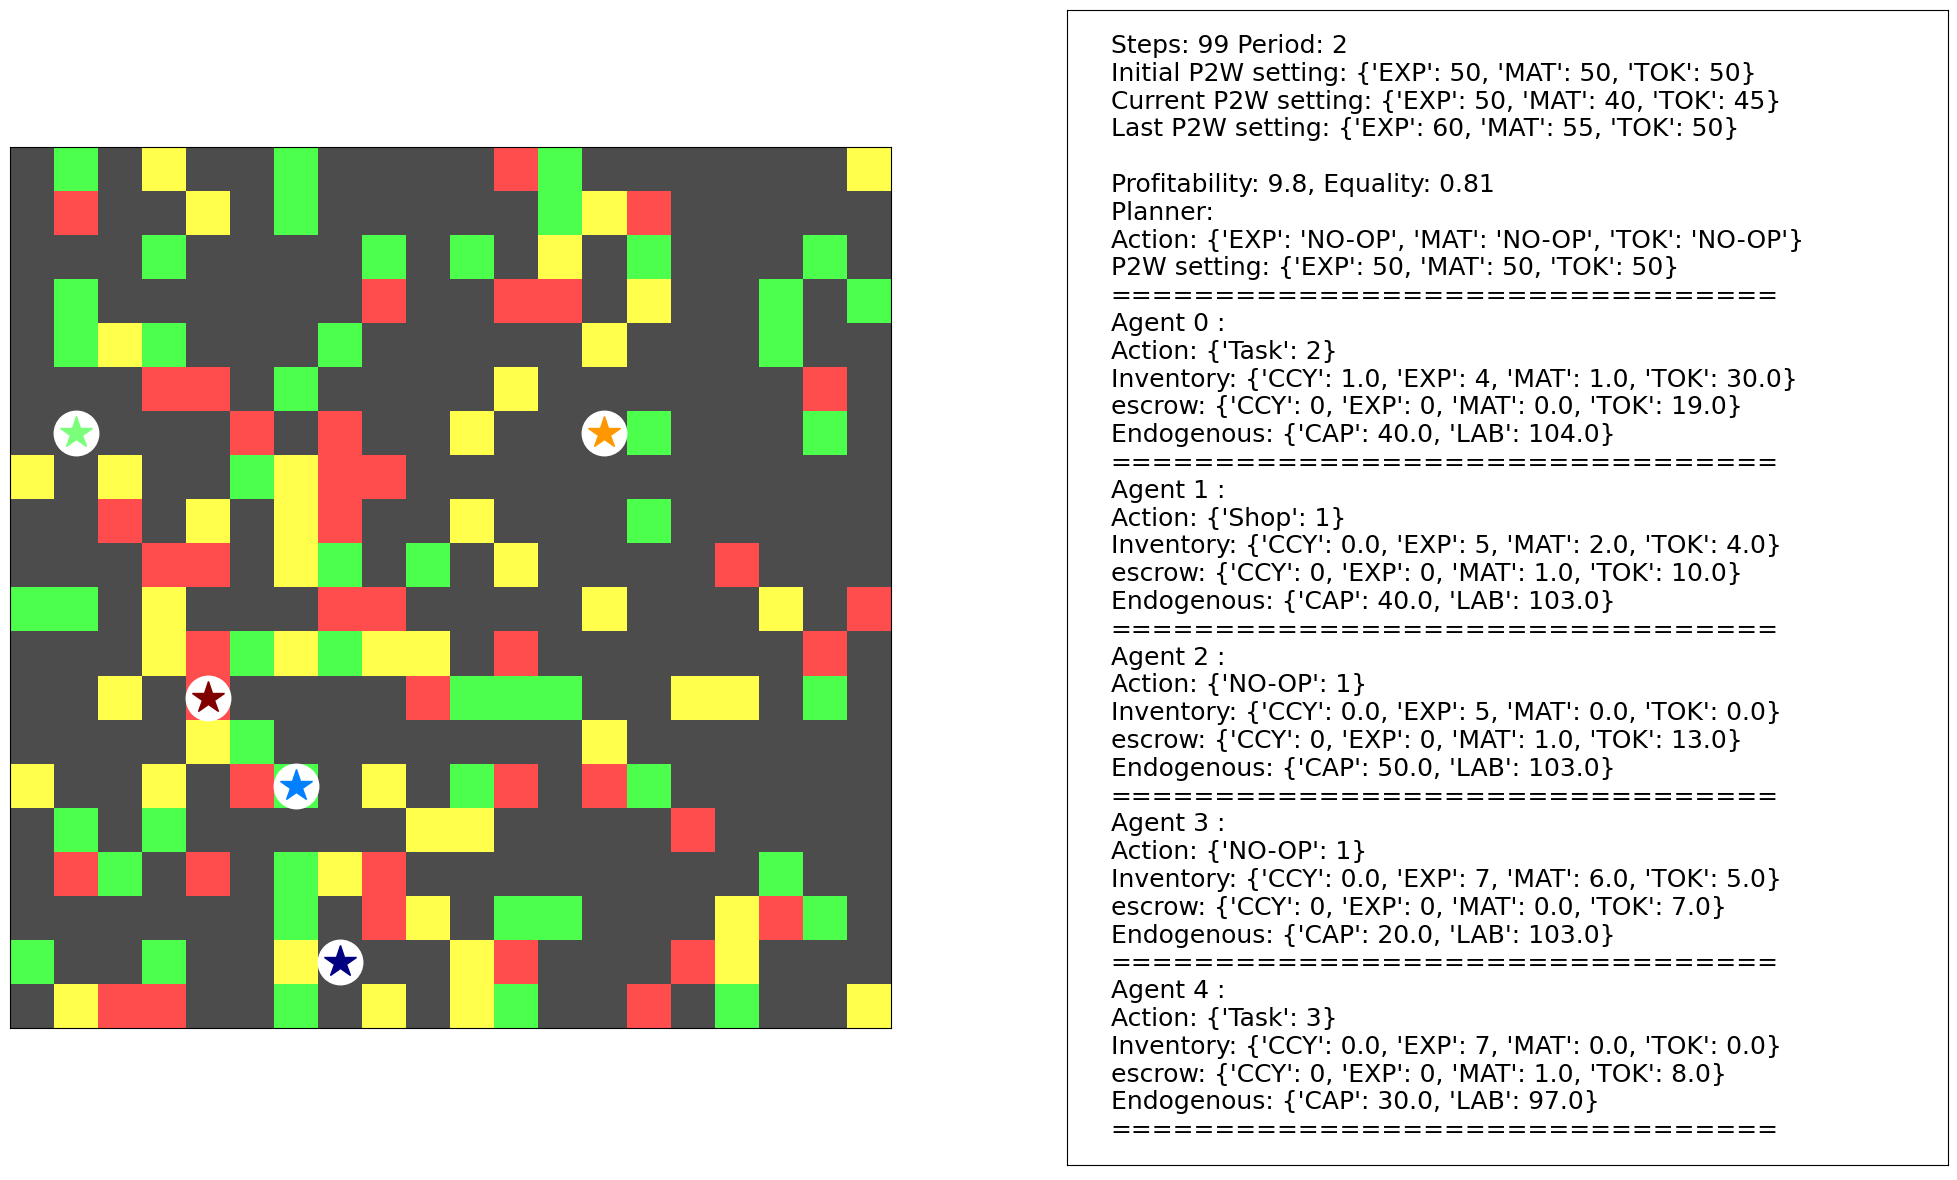

In [34]:
env = foundation.make_env_instance(**env_config)
play_random_episode(env, plot_every=1, do_dense_logging=True)
dense_log = env.previous_episode_dense_log

(<Figure size 960x300 with 3 Axes>,
 <Figure size 1600x400 with 4 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x800 with 10 Axes>)

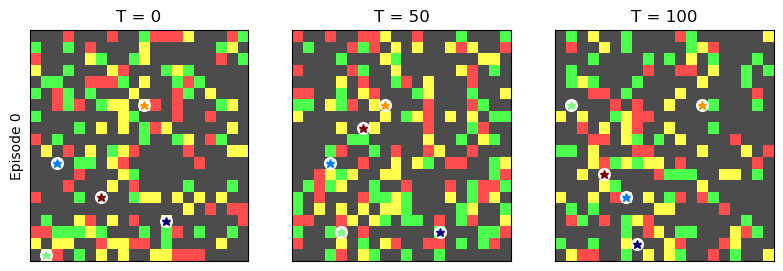

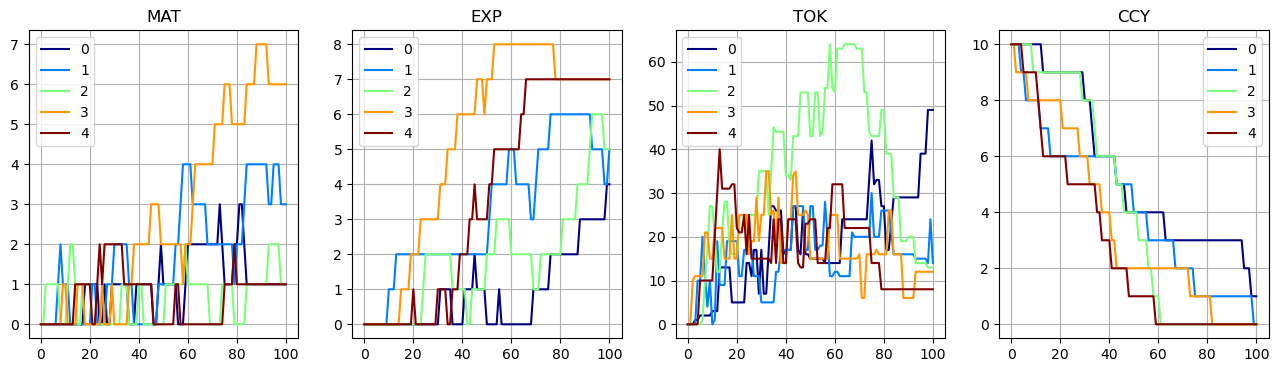

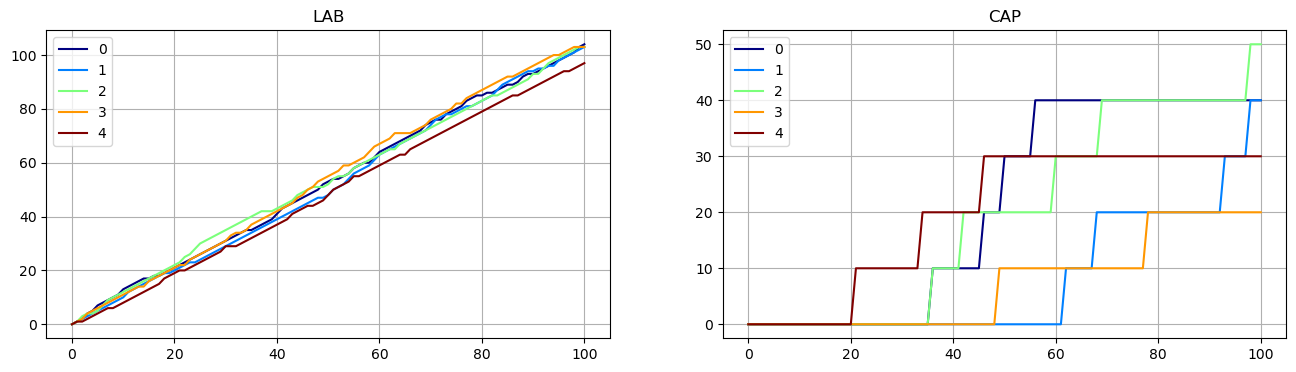

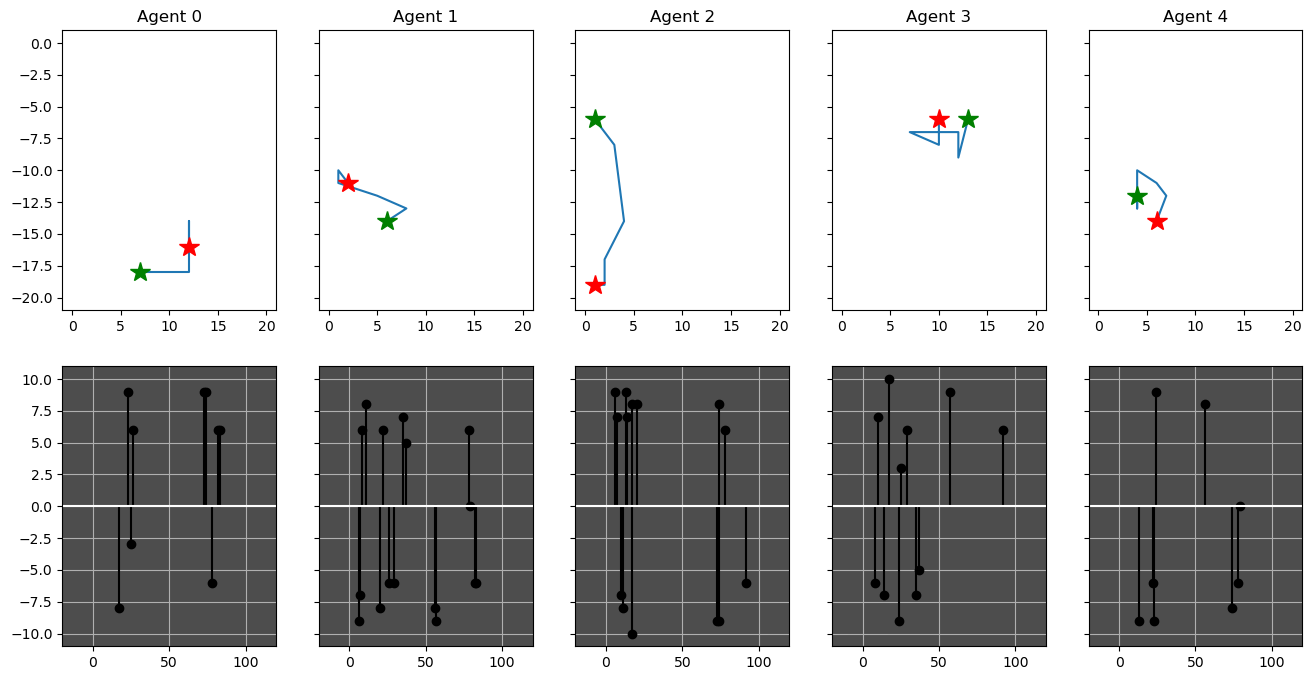

In [35]:
plotting.breakdown(dense_log)